
Stitched 1D Forward Simulation
==============================

Here we use the module *SimPEG.electromangetics.time_domain_1d* to predict
time electromagnetic domain (TDEM) data for a set of "stitched" 1D soundings. That is, the data
for each source is predicted for a separate, user-defined 1D model.
In this tutorial, we focus on the following:

    - Defining receivers, sources and the survey for the stitched 1D case
    - Constructing a stitched model - a set of 1D vertical conductivity profiels
    - Running a TDEM simulation

For each sounding, our survey geometry consists of a horizontal loop source with a
radius of 10 m located 30 m above the Earth's surface. The receiver is located at the centre
of the loop and measures the vertical component of the response.




## Import Modules


In [1]:
import numpy as np
from scipy.spatial import Delaunay, cKDTree
import os
import time
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from discretize import TensorMesh
from pymatsolver import PardisoSolver

from SimPEG import maps, utils
from SimPEG.utils import mkvc
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG.electromagnetics.utils.em1d_utils import plot_layer, get_vertical_discretization_time, set_mesh_1d, Stitched1DModel


#### make the jupyter notebook full window width:

In [2]:
#plt.rcParams.update({'font.size': 16})
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Create Survey

Here we demonstrate a general way to define receivers, sources and the survey.
For this tutorial, we define a line of equally spaced 1D soundings along the Easting direction. However, there is no restriction on the spacing and position of each sounding.

In [3]:
nx = 501
ny = 1
x = np.arange(nx)*25
y = np.arange(ny)*100
z = np.array([20.])

xyz = utils.ndgrid(x, y, z)
np.random.seed(1)
xyz[:,1] += np.random.randn(nx*ny) * 5
xyz[:,2] += xyz[:,0]/np.max(xyz[:,0])*20     # changing altitude!
n_sounding = xyz.shape[0]
source_locations = xyz  # xyz locations for the centre of the loop
source_current = 1.
source_radius = 10.

receiver_locations = xyz   # xyz locations for the receivers
receiver_orientation = "z"            # "x", "y" or "z"
times = np.logspace(-5, -2, 16)       # time channels

# Define the waveform. In this case all sources use the same waveform.
waveform = tdem.sources.StepOffWaveform()

# For each sounding, we define the source and the associated receivers.
source_list = []
for ii in range(0, n_sounding):

    # Source and receiver locations
    source_location = mkvc(source_locations[ii, :])
    receiver_location = mkvc(receiver_locations[ii, :])

    # Receiver list for source i
    receiver_list = [
        tdem.receivers.PointMagneticFluxTimeDerivative(
            receiver_location, times, orientation=receiver_orientation
        )
    ]

    # Source ii
    source_list.append(
        tdem.sources.CircularLoop(
            receiver_list=receiver_list, location=source_location, waveform=waveform,
            radius=source_radius, current=source_current, i_sounding=ii
        )
    )

# Define the survey
survey = tdem.Survey(source_list)
sounding_types = np.ones(n_sounding, dtype=int)
survey._sounding_types = sounding_types


# Defining a Global Mesh and Model

It is easy to create and visualize 2D and 3D models in SimPEG, as opposed to an arbitrary set of local 1D models. Here, we create a 2D model which represents the global conductivity structure of the Earth. In the next part of the tutorial, we will demonstrate how the set of local 1D models can be extracted and organized for the stitched 1D simulation. This process can be adapted easily for 3D meshes and models.

In [4]:
# line number
line = (np.arange(ny).repeat(nx)).astype(float)
# time stamp
time_stamp = np.arange(n_sounding).astype(float)
# topography
topography = np.c_[xyz[:,:2], np.zeros(n_sounding)]
# vertical cell widths
hz = 10*np.ones(40)

# A function for generating a wedge layer 
def get_y(x, x_max):
    y = 300/x_max * x + 70.
    return y

# Conductivity values for each unit
background_conductivity = 1./100.
layer_conductivity = 1./100.

# Define a 1D vertical mesh
mesh_1d = set_mesh_1d(hz)
# Generate a stitched 1D model
n_layer = hz.size
conductivity = np.zeros((n_sounding, n_layer), dtype=float)

for i_sounding in range(n_sounding):
    y = get_y(xyz[i_sounding, 0], xyz[:, 0].max())
    layer_ind = np.logical_and(mesh_1d.vectorCCx>50., mesh_1d.vectorCCx<y)
    conductivity_1d = np.ones(n_layer, dtype=float) * background_conductivity
    conductivity_1d[layer_ind] = layer_conductivity
    conductivity[i_sounding,:]=conductivity_1d

# Note: oder of the conductivity model 
stitched_conductivity_model = conductivity.flatten()



/usr/local/lib/python3.8/dist-packages/discretize/utils/code_utils.py:216: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


### Plot model

/usr/local/lib/python3.8/dist-packages/SimPEG/electromagnetics/utils/em1d_utils.py:540: UserWarning: code under construction - API might change in the future
  warnings.warn(


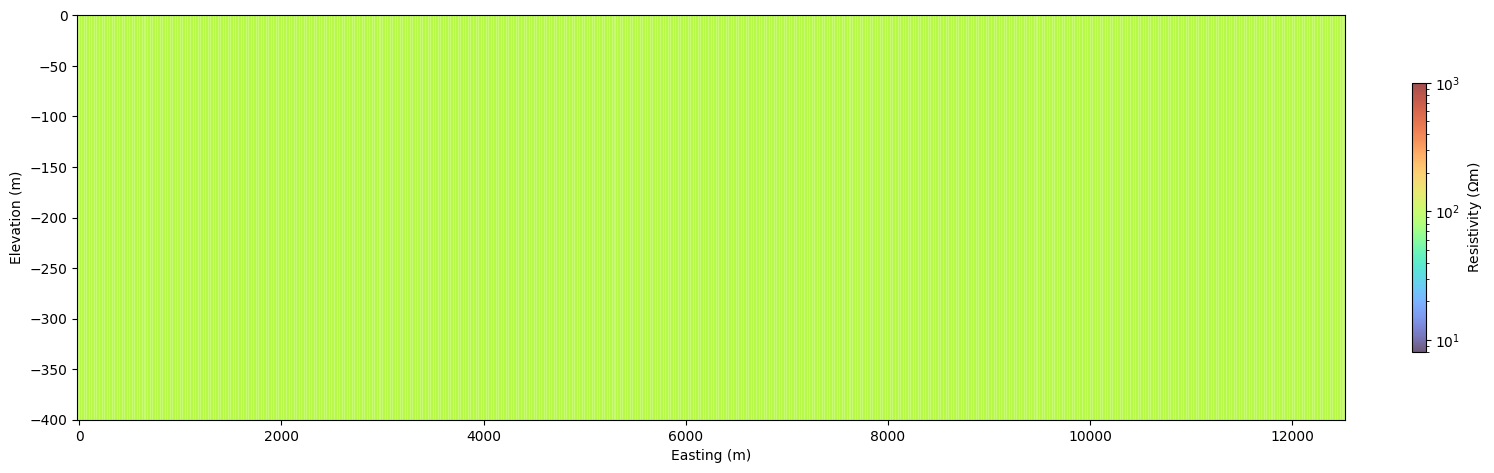

In [5]:
# Generate a Stitched1DModel object for plotting
model_plot = Stitched1DModel(
    hz=hz,
    line=line,
    time_stamp=time_stamp,
    topography=topography,
    physical_property=1./stitched_conductivity_model,
    n_layer=len(hz)
)

_, ax, cb = model_plot.plot_section(cmap='turbo', aspect=0.5, dx=20, i_line=0, clim=(8, 1000))
cb.set_label("Resistivity ($\Omega$m)")

ax.set_aspect(10)

# the optimum layer thicknesses for a set number of layers. Note that when defining
# the thicknesses, it is the number of layers minus one.
thicknesses = hz[:-1]

# Define the Mapping, Forward Simulation and Predict Data

Here we define the simulation and predict the TDEM data. The simulation requires the user define the survey, the layer thicknesses and a mapping from the model to the conductivities. When using the *SimPEG.electromagnetics.time_domain_1d* module, predicted data are organized by source (sounding), then by receiver, then by time channel.


In [6]:


# Model and mapping. Here the model is defined by the log-conductivity.
stitched_model = np.log(stitched_conductivity_model)
mapping = maps.ExpMap(nP=len(stitched_model))

# Define the simulation
simulation = tdem.Simulation1DLayeredStitched(
    survey=survey, thicknesses=thicknesses, sigmaMap=mapping,
    topo=topography,
    parallel=True, n_cpu=4, 
    n_layer=n_layer
)

# Predict data
start = time.time()
dpred = simulation.dpred(stitched_model)
end = time.time()
print("\nTime used for fwd-modelling:{0:5.2f} min".format( (end - start)/60))


Time used for fwd-modelling: 0.12 min


In [7]:
simulation.topo

array([[ 0.00000000e+00,  8.12172682e+00,  0.00000000e+00],
       [ 2.50000000e+01, -3.05878207e+00,  0.00000000e+00],
       [ 5.00000000e+01, -2.64085876e+00,  0.00000000e+00],
       ...,
       [ 1.24500000e+04, -5.53856251e+00,  0.00000000e+00],
       [ 1.24750000e+04, -8.85915896e-02,  0.00000000e+00],
       [ 1.25000000e+04, -8.59697237e+00,  0.00000000e+00]])

In [8]:
simulation.survey.source_location_by_sounding_dict

{0: [array([ 0.        ,  8.12172682, 20.        ])],
 1: [array([25.        , -3.05878207, 20.04      ])],
 2: [array([50.        , -2.64085876, 20.08      ])],
 3: [array([75.        , -5.36484311, 20.12      ])],
 4: [array([100.        ,   4.32703815,  20.16      ])],
 5: [array([125.        , -11.50769348,  20.2       ])],
 6: [array([150.        ,   8.72405882,  20.24      ])],
 7: [array([175.       ,  -3.8060345,  20.28     ])],
 8: [array([200.        ,   1.59519548,  20.32      ])],
 9: [array([225.        ,  -1.24685188,  20.36      ])],
 10: [array([250.        ,   7.31053969,  20.4       ])],
 11: [array([275.        , -10.30070355,  20.44      ])],
 12: [array([300.        ,  -1.61208602,  20.48      ])],
 13: [array([325.        ,  -1.92027177,  20.52      ])],
 14: [array([350.        ,   5.66884721,  20.56      ])],
 15: [array([375.        ,  -5.49945634,  20.6       ])],
 16: [array([400.        ,  -0.86214104,  20.64      ])],
 17: [array([425.        ,  -4.38929209

# Plotting Results


In [14]:

d = np.reshape(dpred, (n_sounding, len(times)))

Text(0.5, 0, 'northing [m]')

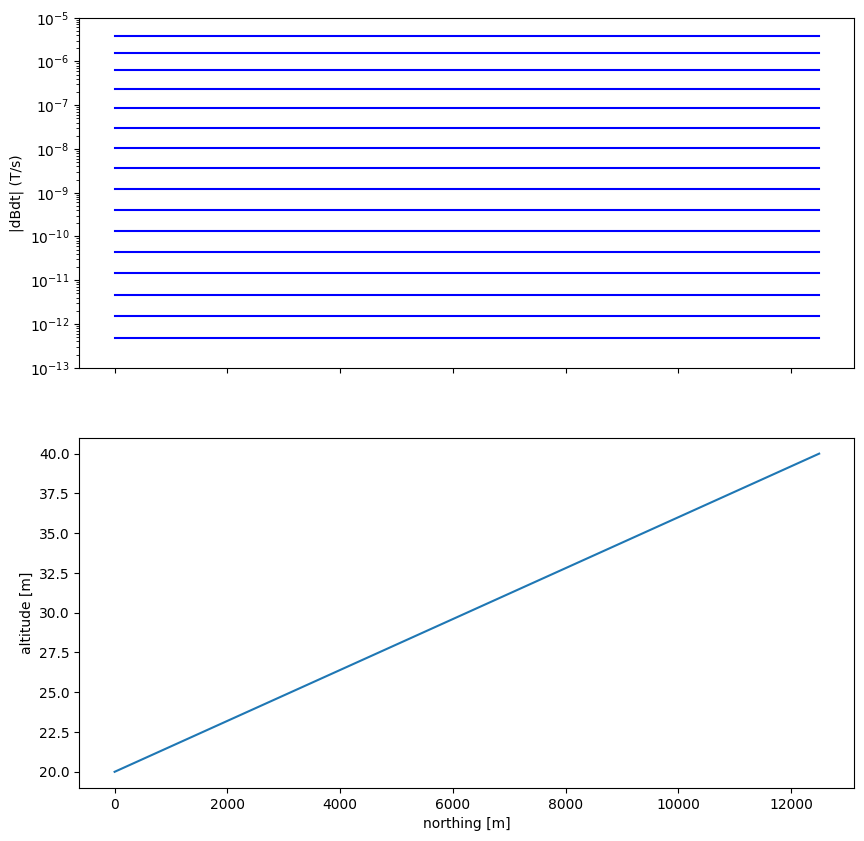

In [15]:

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax[0].semilogy(receiver_locations[:, 0], np.abs(d), 'b-', ms=2,  label='obs')  # measured data

ax[0].set_ylabel("|dBdt| (T/s)")
#ax.set_title("Line nubmer {:.0f}".format(i_line))
ax[0].set_ylim([1e-13, 1e-5])

ax[1].plot(source_locations[:, 0], source_locations[:, 2])
ax[1].set_ylabel('altitude [m]')
ax[1].set_xlabel("northing [m]")